Zbiór danych: https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland?resource=download

Dataset zawiera informacje o nieruchomościach na sprzedaż w Polsce z czerwca 2024r  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = 'apartments_pl_2024_06.csv'

apartments_data = pd.read_csv(data_path)

num_rows, num_columns = apartments_data.shape

print(f"Liczba rekordów (wierszy): {num_rows}")
print(f"Liczba cech (kolumn): {num_columns}")

pd.set_option('display.max_columns', None)
print(apartments_data.head())

Liczba rekordów (wierszy): 21501
Liczba cech (kolumn): 28
                                 id      city               type  \
0  811891f98a870dfd6e414374a0a85560  szczecin       blockOfFlats   
1  adaf636d0c44d8d9325bce42403eefee  szczecin  apartmentBuilding   
2  9b957bd60885a469c96f17b58a914f4b  szczecin  apartmentBuilding   
3  74fef2ff7135bc70797a3fbfd7d44ed6  szczecin       blockOfFlats   
4  77cc78c75b0d09bf84d6d3124a28803c  szczecin       blockOfFlats   

   squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  \
0         47.00    2.0    6.0        12.0     1981.0  53.428544  14.552812   
1         88.22    3.0    1.0         2.0     2000.0  53.449093  14.516844   
2        117.00    5.0    4.0         4.0        NaN  53.443096  14.561348   
3         33.31    1.0    1.0         4.0     1963.0  53.436100  14.541200   
4         56.00    3.0    7.0         7.0     2018.0  53.447465  14.557811   

   centreDistance  poiCount  schoolDistance  clinicDistance  \
0

Zbiór zawiera 21501 rekordów, liczba cech w całym zbiorze wynosi 28. Do przeprowadzenia regresji zostaną wykorzystane następujące cechy:

1. squareMeters (metry kwadratowe)  
2. city (miasto)
3. rooms (ilość pokoi)  
4. floor (piętro)  
5. floorCount (ilość pięter w budynku)  
6. buildYear (rok budowy)  
7. latitude i longitude - współrzędne geograficzne lokalizacji mieszkania.  
8. hasElevator (winda)  - nie posiada / posiada
9. hasParkingSpace (miejsce parkingowe) - nie posiada / posiada  
10. hasStorageRoom (komórka lokatorkska) - nie posiada / posiada
11. type (rodzaj nieruchomości) - mieszkanie, kamienica, apartament
12. building material - cegla, plyta betonowa
13. price (cena) - cena mieszkania (zł)  

Zbiór posłuży do przeprowadzenia regresji cen mieszkań, z wykorzystaniem powyższych cech.

In [13]:
selected_columns = [
    "squareMeters", "rooms", "floor", "floorCount", "buildYear",
    "latitude", "longitude", "poiCount", "hasStorageRoom", "type",
    "buildingMaterial", "hasElevator", "hasParkingSpace", "price",
]

missing_values = apartments_data[selected_columns].isnull().sum()

missing_percentage = (missing_values / len(apartments_data) * 100).round(2).astype(str) + "%"

print("Brakujące wartości dla cech używanych w regresji:")
print(missing_percentage)

Brakujące wartości dla cech używanych w regresji:
squareMeters          0.0%
rooms                 0.0%
floor               16.62%
floorCount           0.97%
buildYear           15.72%
latitude              0.0%
longitude             0.0%
poiCount              0.0%
hasStorageRoom        0.0%
type                20.45%
buildingMaterial    40.89%
hasElevator          4.46%
hasParkingSpace       0.0%
price                 0.0%
dtype: object


In [15]:
error_counts = {}

valid_values = {
    "hasElevator": ["yes", "no"],
    "hasParkingSpace": ["yes", "no"],
    "hasStorageRoom": ["yes", "no"],
    "type": ["blockOfFlats", "apartmentBuilding", "tenement"],
    "buildingMaterial": ["brick", "concreteSlab"],
}

for col, valid in valid_values.items():
    invalid_values = apartments_data[~apartments_data[col].isin(valid)][col].dropna()
    error_counts[col] = len(invalid_values)

valid_ranges = {
    "squareMeters": (10, 500),
    "rooms": (1, 10),
    "floor": (0, 50),
    "floorCount": (1, 50),
    "buildYear": (1800, 2025),
    "centreDistance": (0, 100),
    "schoolDistance": (0, 100),
    "clinicDistance": (0, 100),
    "pharmacyDistance": (0, 100),
    "price": (50000, 5000000),
    "latitude": (-90, 90),
    "longitude": (-180, 180),
}

for col, (min_val, max_val) in valid_ranges.items():
    invalid_values = apartments_data[(apartments_data[col] < min_val) | (apartments_data[col] > max_val)][col]
    error_counts[col] = len(invalid_values)

total_rows = len(apartments_data)
for col, count in error_counts.items():
    percent = round((count / total_rows) * 100, 2)
    print(f"{col.ljust(20)} {str(count).ljust(5)} ({percent}%)")

hasElevator          0     (0.0%)
hasParkingSpace      0     (0.0%)
hasStorageRoom       0     (0.0%)
type                 0     (0.0%)
buildingMaterial     0     (0.0%)
squareMeters         0     (0.0%)
rooms                0     (0.0%)
floor                0     (0.0%)
floorCount           0     (0.0%)
buildYear            0     (0.0%)
centreDistance       0     (0.0%)
schoolDistance       0     (0.0%)
clinicDistance       0     (0.0%)
pharmacyDistance     0     (0.0%)
price                0     (0.0%)
latitude             0     (0.0%)
longitude            0     (0.0%)


Zbiór nie zawiera niepoprawnych wartości.  

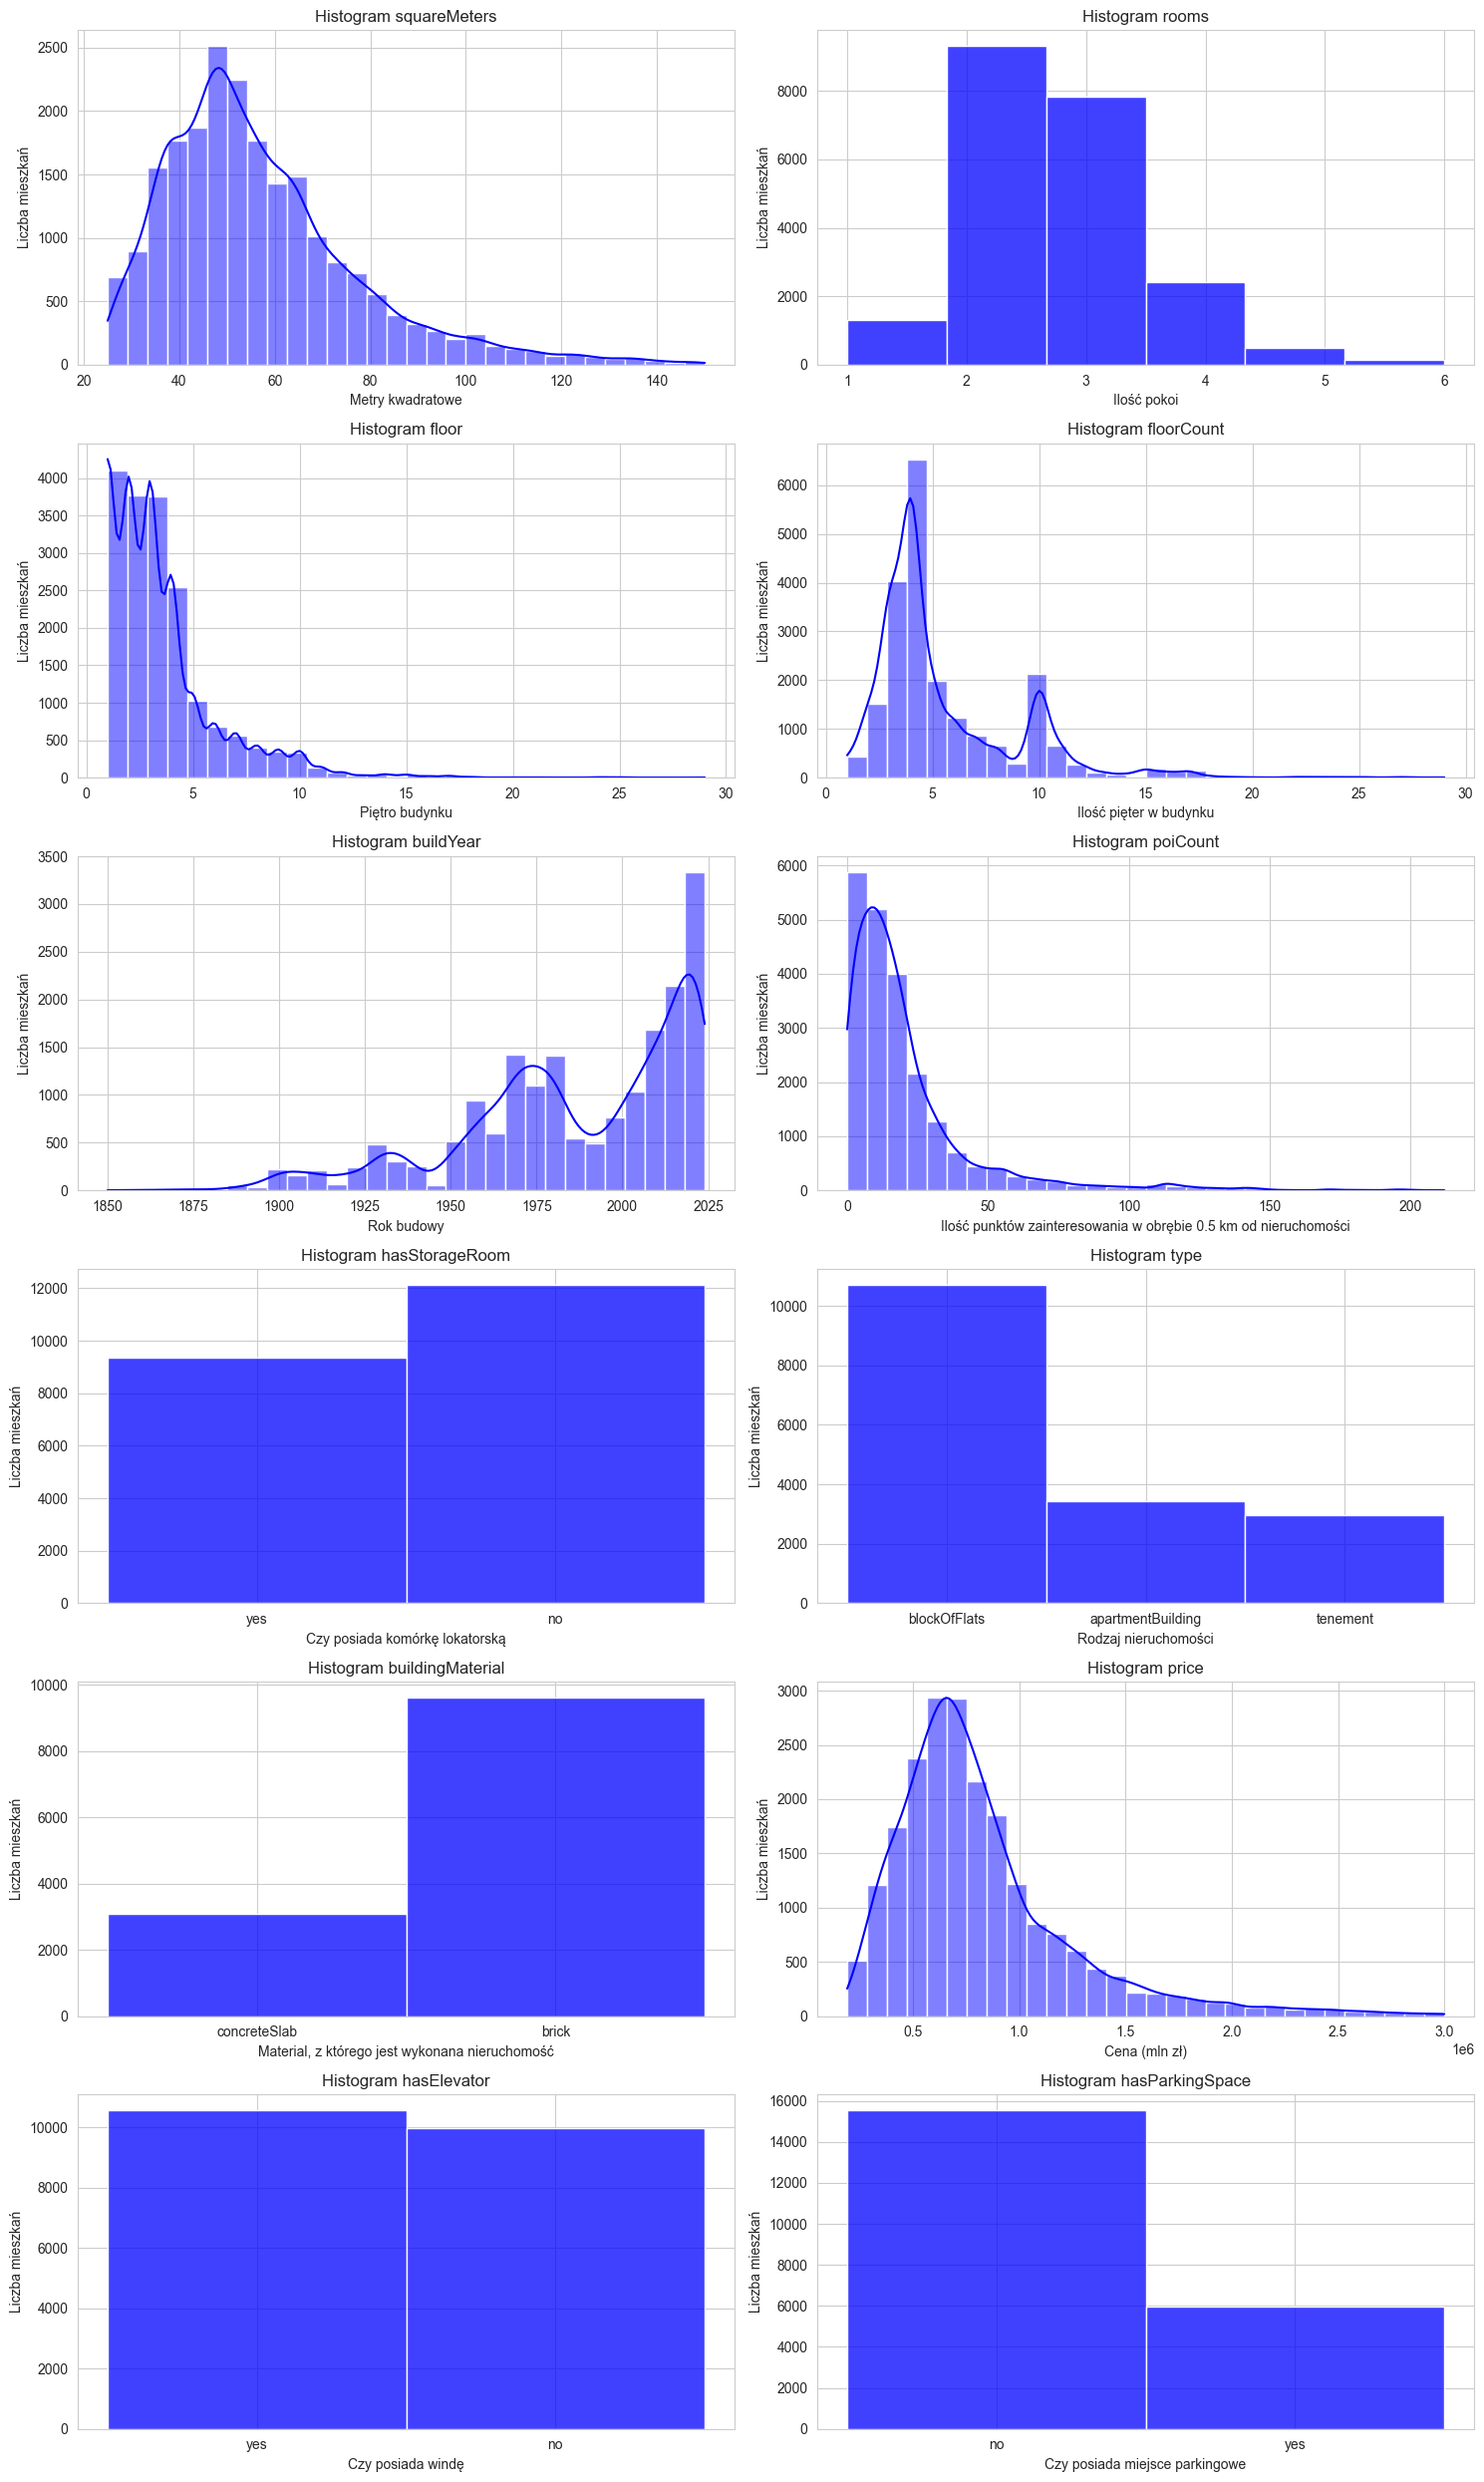

In [17]:
def create_hist_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="blue", bins=30, kde=True):
    sns.histplot(data[column], bins=bins, kde=kde, color=color, ax=axes[index])
    axes[index].set_title(f"Histogram {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(6, 2, figsize=(15, 25))
axes = axes.flatten()

create_hist_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_hist_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi", bins=6, kde=False)
create_hist_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_hist_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_hist_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_hist_plot(5, apartments_data, "poiCount", axes,
                 xlabel="Ilość punktów zainteresowania w obrębie 0.5 km od nieruchomości")
create_hist_plot(6, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską", kde=False)
create_hist_plot(7, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości", kde=False)
create_hist_plot(8, apartments_data, "buildingMaterial", axes, xlabel="Material, z którego jest wykonana nieruchomość",
                 kde=False)
create_hist_plot(9, apartments_data, "price", axes, xlabel="Cena (mln zł)")
create_hist_plot(10, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę", kde=False)
create_hist_plot(11, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe", kde=False)

plt.tight_layout()
plt.show()

1. Metraż mieszkań - Większość mieszkań na rynku ma powierzchnię między 40 a 70 m², ze średnią wynoszącą około 57 m². Widoczna jest asymetria rozkładu w stronę mniejszych mieszkań.
2. Liczba pokoi - Dominują mieszkania 2 i 3 pokojowe, które stanowią największą część oferty rynkowej.
3. Piętro - Najczęściej spotykane są mieszkania na 1-4 piętrze. 
4. Ilość pięter w budynku - Przeważają budynki 4-piętrowe, choć rozkład jest zróżnicowany.
5. Rok budowy - Zauważalny jest wyraźny dwumodalny rozkład z dwoma szczytami: jeden dla budynków z lat 1970-1980 (okres PRL) i drugi dla nowych inwestycji po 2000 roku
6. Cena - Rozkład cen jest asymetryczny, z przewagą mieszkań w przedziale 500-900k pln.
7. Czy poisada miejsce parkingowe - Większość nieruchmości nie posiada miejsca parkingowego
8. Czy posiada windę - Co druga nieruchomość posiada windę
9. Material budowlany - 70% nieruchomości wykonana jest z cegly, pozostala z betonowej plyty.
10. Rodzaj nieruchomości - Dominują mieszkania w bloku / kamienicy

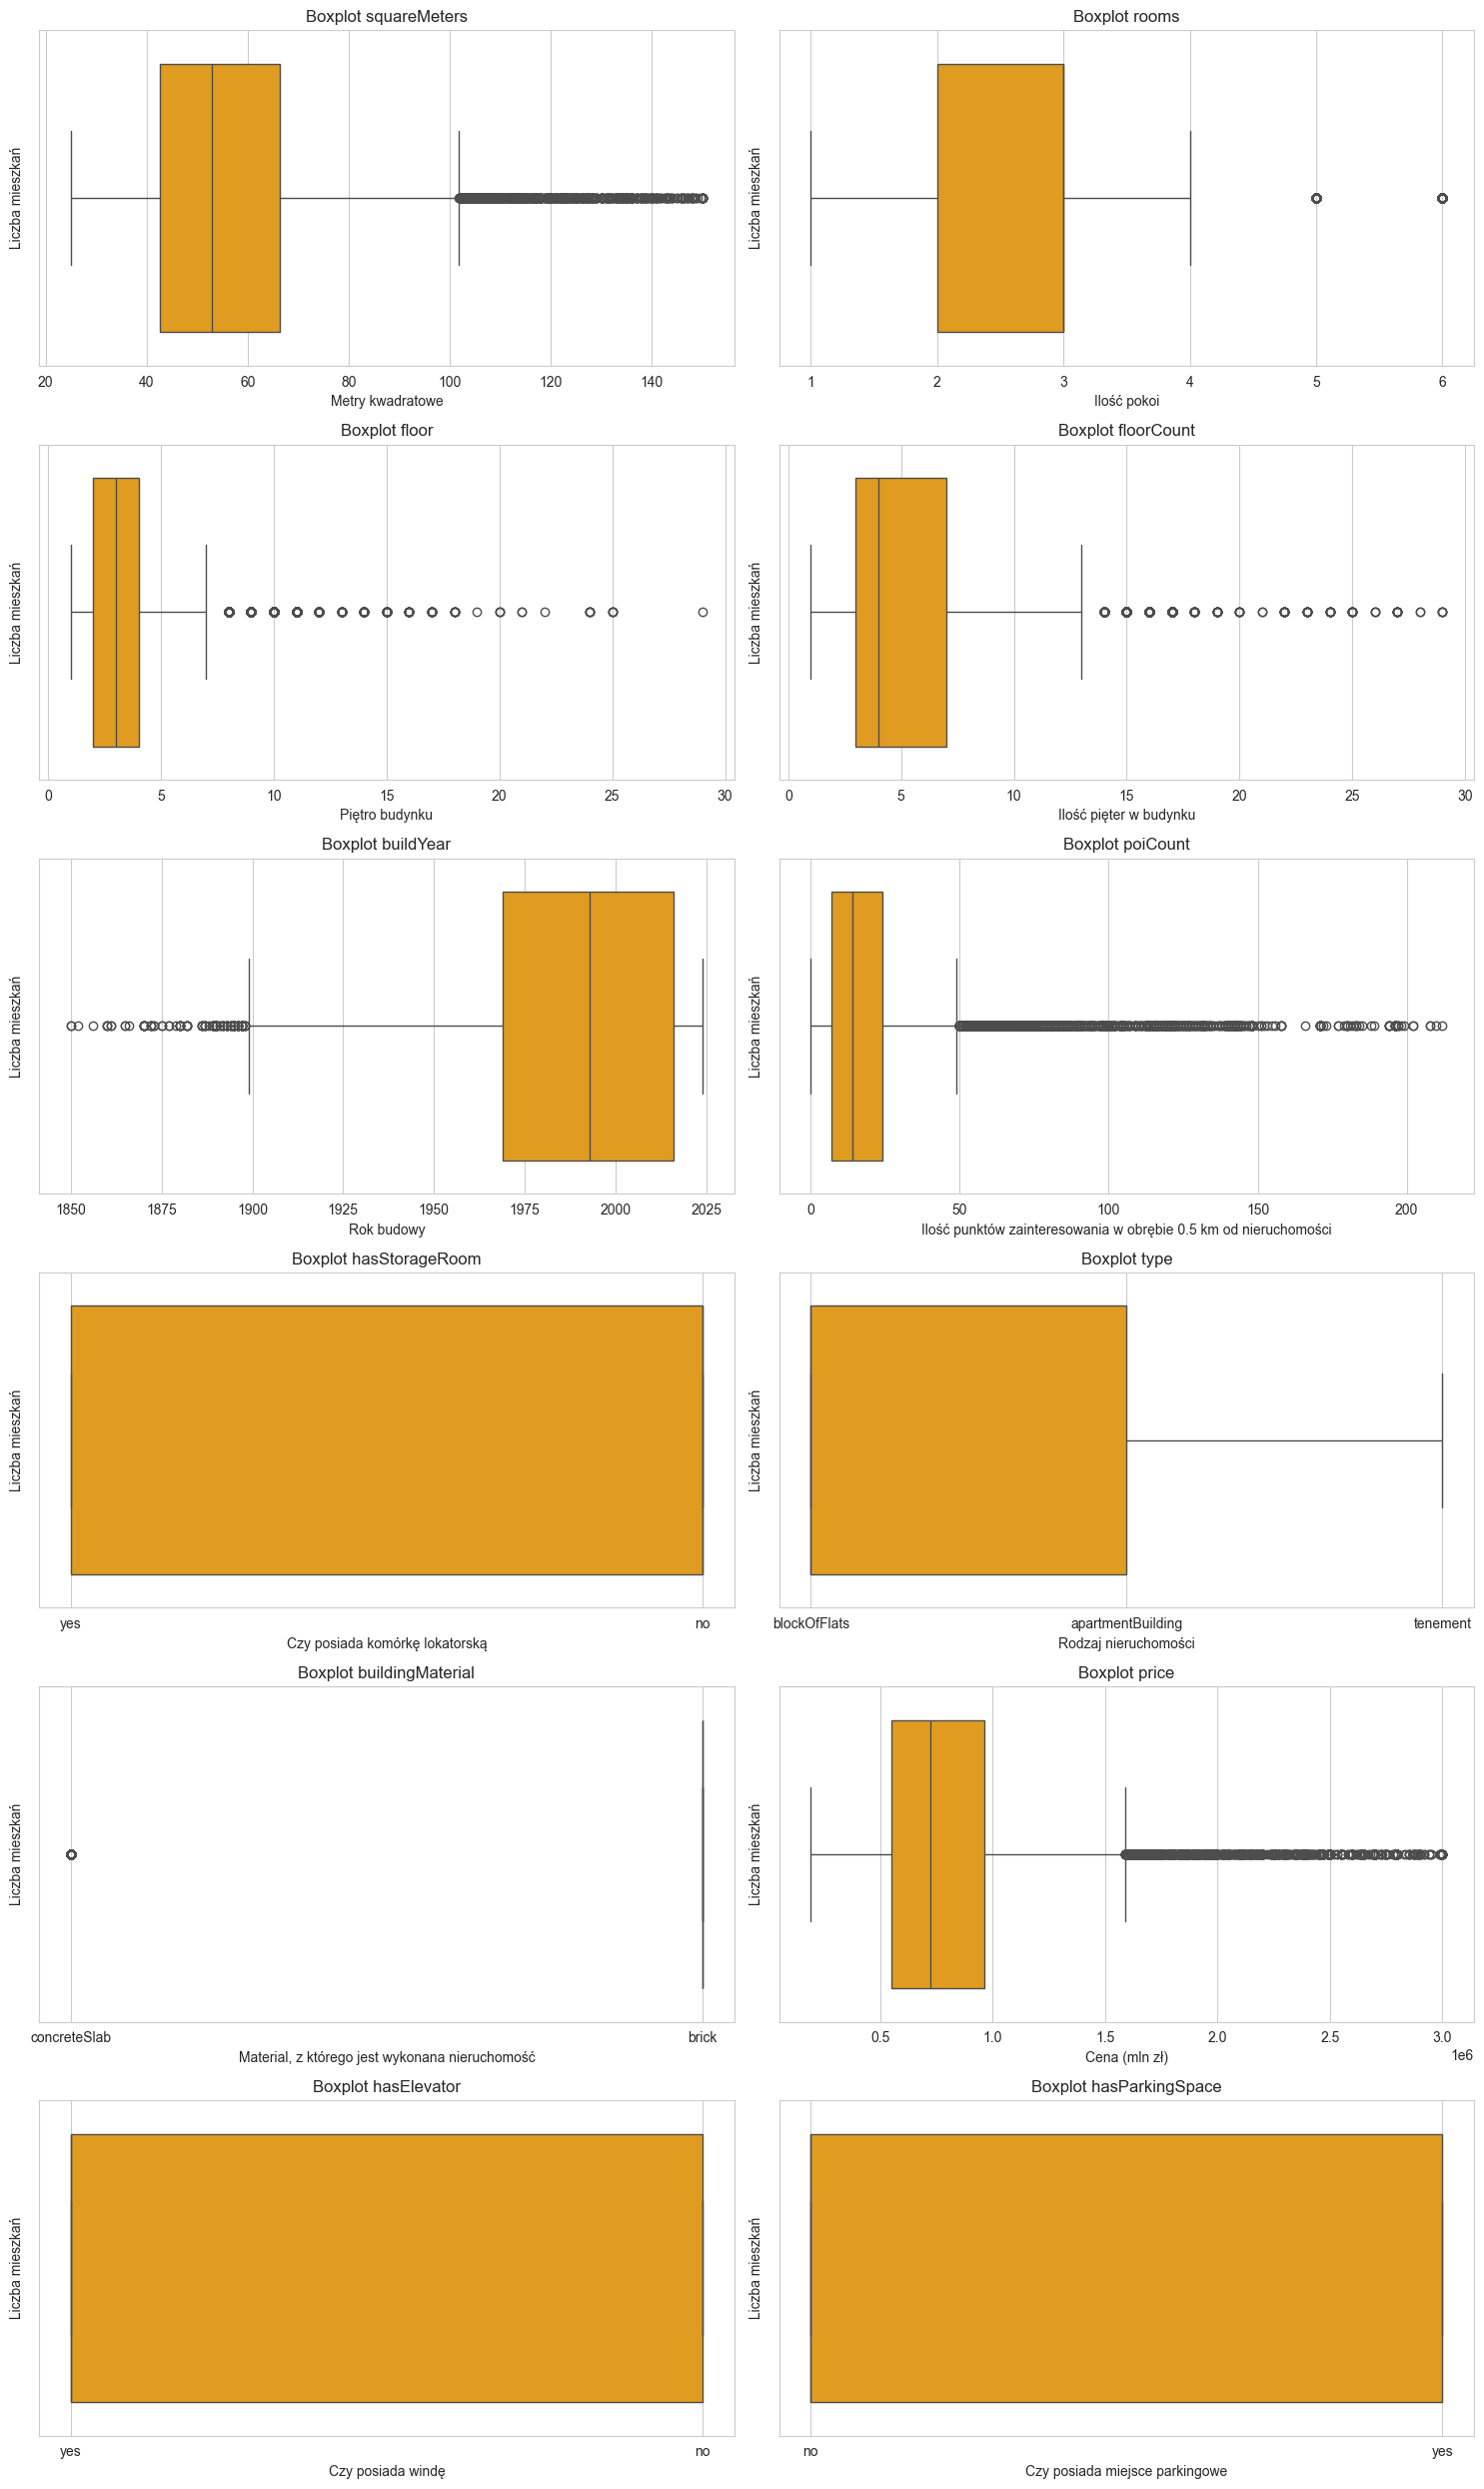

In [19]:
def create_box_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="orange"):
    sns.boxplot(data[column], color=color, ax=axes[index], orient='h')
    axes[index].set_title(f"Boxplot {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(6, 2, figsize=(15, 25))
axes = axes.flatten()

create_box_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_box_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi")
create_box_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_box_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_box_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_box_plot(5, apartments_data, "poiCount", axes,
                xlabel="Ilość punktów zainteresowania w obrębie 0.5 km od nieruchomości")
create_box_plot(6, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską")
create_box_plot(7, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości")
create_box_plot(8, apartments_data, "buildingMaterial", axes, xlabel="Material, z którego jest wykonana nieruchomość")
create_box_plot(9, apartments_data, "price", axes, xlabel="Cena (mln zł)")
create_box_plot(10, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę")
create_box_plot(11, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe")

plt.tight_layout()
plt.show()



Wnioski z owych wykresów są tożsame z tymi spod histogramów.

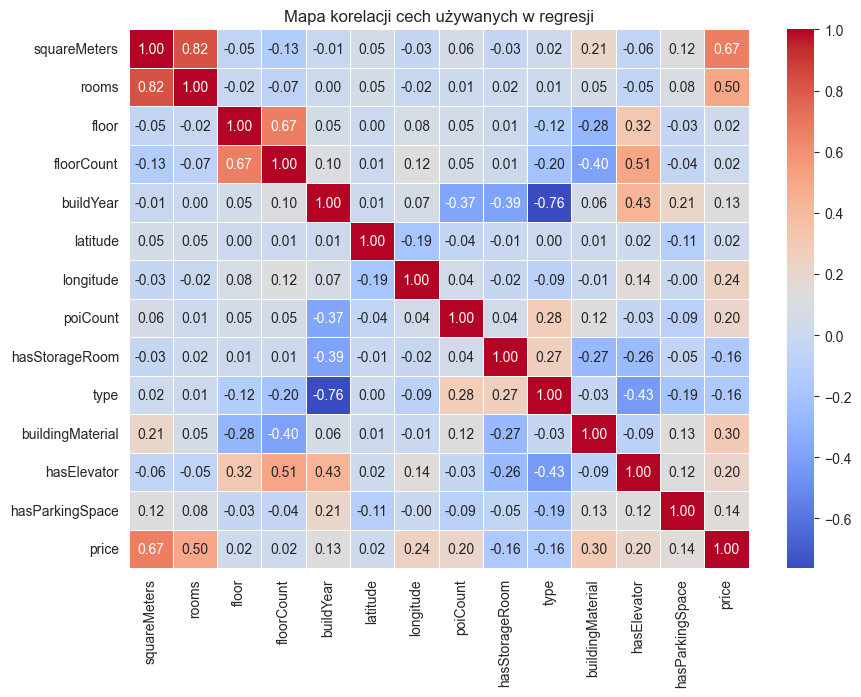

In [20]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["type"] = filtered_data["type"].map({"blockOfFlats": 1, "apartmentBuilding": 0, "tenement": 2}).astype(
    "Int64")
filtered_data["hasStorageRoom"] = filtered_data["hasStorageRoom"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["buildingMaterial"] = filtered_data["buildingMaterial"].map({"brick": 1, "concreteSlab": 0}).astype(
    "Int64")

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

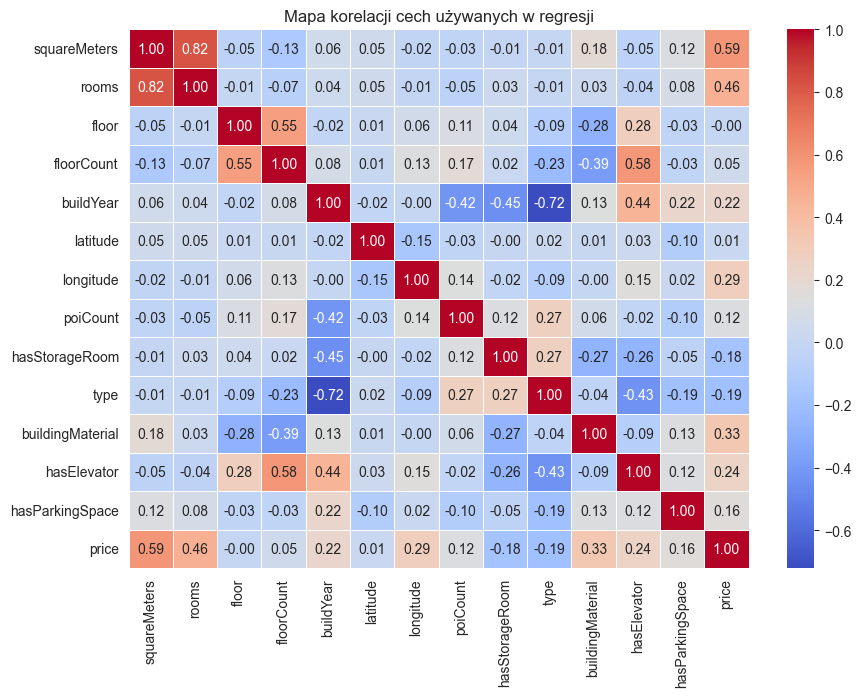

In [21]:
corr_matrix = filtered_data.corr(method='spearman')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

Wnioski:
1. Metraż i liczba pokoi - Najsilniejsza korelacja w obu metodach (Pearson: 0.82, Spearman: 0.82)
   - Zależność ta jest oczywista i potwierdza, że większe mieszkania posiadają więcej pokoi.

2. Metraż i cena - Bardzo silna korelacja (Pearson: 0.67, Spearman: 0.59)
   - Potwierdza, że powierzchnia mieszkania jest kluczowym czynnikiem wpływającym na jego cenę.

3. Liczba pięter w budynku i obecność windy - Silna korelacja (Pearson: 0.51, Spearman: 0.58)
   - Im wyższy budynek, tym większe prawdopodobieństwo, że posiada windę.

4. Piętro i liczba pięter w budynku - Silna korelacja (Pearson: 0.67, Spearman: 0.55)
   - Mieszkania na wyższych piętrach znajdują się częściej w wyższych budynkach.

5. Rok budowy i obecność windy - Wyraźna korelacja (Pearson: 0.43, Spearman: 0.44)
   - Nowsze budynki częściej wyposażone są w windy.

6. Liczba pokoi i cena - Znacząca korelacja (Pearson: 0.50, Spearman: 0.46)
   - Potwierdza wpływ liczby pokoi na cenę mieszkania.


In [22]:
avg_prices = apartments_data[['city', 'price']].copy().groupby('city')['price'].agg(['mean', 'count']).reset_index()

avg_prices.columns = ['City', 'Average Price', 'Number of properties']

avg_prices['Average Price'] = avg_prices['Average Price'].round(0).astype(int)

avg_prices = avg_prices.sort_values('Average Price', ascending=False)
avg_prices

,City,Average Price,Number of properties
13,warszawa,1053134,6962
6,krakow,942169,3245
3,gdansk,891338,1986
4,gdynia,884685,828
14,wroclaw,745965,2271
9,poznan,647102,793
11,rzeszow,636871,163
8,lublin,581739,574
12,szczecin,572549,647
5,katowice,528240,593


Jak można zauważyć na powyższym zestawieniu najwyższa średnia cena transakcyjna występuje w stolicy polski i wynosi: 1,053,134 pln. Na drugim miejscu plasuje się Kraków z średnią ceną niższą o 110 tys. pln niż Warszawa tj. 942,169 pln

In [5]:
import folium
from folium.plugins import HeatMap

cracow_df = apartments_data[apartments_data['city'] == 'krakow'].copy()

center_lat = cracow_df['latitude'].mean()
center_lng = cracow_df['longitude'].mean()

points = cracow_df[['latitude', 'longitude']].values.tolist()

cracow_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)

HeatMap(points).add_to(cracow_map)

cracow_map

Mapa cieplna przedstawia geograficzny rozkład ofert nieruchomości w Krakowie, ukazując ich koncentrację w poszczególnych częściach miasta. Najwyższa gęstość ofert znajduje się w centrum, co wskazuje na duże zapotrzebowanie na nieruchomości w tej lokalizacji. Dzielnice takie jak Stare Miasto i Kazimierz cieszą się szczególną popularnością. Mniejsza liczba ofert na obrzeżach Krakowa wskazuje na niższe zainteresowanie lub ograniczoną podaż w tych rejonach.